# Koopman-based System Identification of Brunton's Toy Example

In [42]:
import numpy as np
from scipy import linalg, integrate
from scipy.integrate import solve_ivp
from scipy.linalg import logm
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import itertools
import sympy as sp
np.set_printoptions(suppress=True, precision=3, linewidth=np.inf)

## Dynamics

\begin{align}
\dot{x_1} &= \mu x_1 \\
\dot{x_2} &= \lambda (x_2 - x_1^2)
\end{align}

In [2]:
class BruntonExample():
    def __init__(self, mu, lmbda):
        self.mu = mu
        self.lmbda = lmbda

    def f(self, t, x):
        x0dot = self.mu * x[0]
        x1dot = self.lmbda * (x[1] - x[0]**2)
        return np.array([x0dot, x1dot])

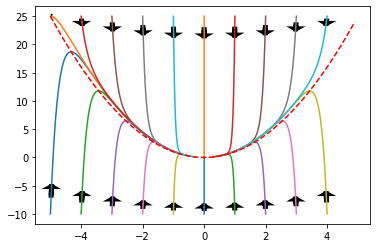

In [12]:
t_range = (0, 25)
dt = 1e-3

sys = BruntonExample(mu=-0.05, lmbda=-1)
t = np.arange(*t_range, dt)

plt.figure()
for x0 in np.arange(-5,5):
    for x1 in [-10,25]:
        sol = solve_ivp(sys.f, t_range, (x0,x1), t_eval=t)
        x0s, x1s = sol.y[0], sol.y[1]
        plt.plot(x0s, x1s)
        plt.arrow(x0s[100], x1s[100], x0s[150]-x0s[100], x1s[150]-x1s[100], lw=5)
X = np.arange(-5,5,0.1)
Y = np.apply_along_axis(lambda x: x**2, 0, X)
plt.plot(X,Y, 'r--')
plt.show()
#plt.savefig('bruntons_example.jpg')

## Analytical Solution

Brunton shows in his [notes](https://fluids.ac.uk/files/meetings/KoopmanNotes.1575558616.pdf), section 2.3, that for this system, the state observables are contained within a Koopman-closed subspace of dimension 3! This subspace is spanned by $x_1$, $x_2$, and $x_3 = x_1^2$, and its dynamics are given by

\begin{align*}
\frac{d}{dt}
    \begin{bmatrix}
    x_1\\
    x_2 \\
    x_3
    \end{bmatrix}
    =
    \begin{bmatrix}
    \mu & 0 & 0\\
    0 & \lambda & -\lambda \\
    0 & 0 & 2\mu
    \end{bmatrix}
    \begin{bmatrix}
    x_1\\
    x_2 \\
    x_3
    \end{bmatrix}
\end{align*}

This is the matrix representation of the Koopman operator in the $x_1$, $x_2$, and $x_3 = x_1^2$ basis, and diagonalizing the transpose of this matrix gives the Koopman operator's eigenpairs. Brunton states this fact without justification. See this [blog](https://samlaf.github.io/koopman-bruntons-toy-example.html) for more info.

## Data-Driven Solution

We show that even without access to the state dynamics equations, we can recover the above matrix representation of the Koopman matrix, and hence the Koopman eigenpairs. For this, we choose observables which are polynomial combinations of the state variables, and perform a simple least-squares based sysid.

In [4]:
class PolyLiftedSpace():
    """Class for lifting state-space with polynomial terms.
    Eg. if n_state=2 and poly_deg=2, then state-space transformation is
    (x,y) -> (x,y,x^2,y^2,xy)"""
    def __init__(self, n_states, poly_deg):
        self.n_states = n_states
        self.poly_deg = poly_deg
        self.poly = PolynomialFeatures(poly_deg, include_bias=False)
        
    def lift(self, X):
        return self.poly.fit_transform(X.T).T

In [5]:
def koopman_operator_lsq(X, X_prime,lifted_space):
    """ Returns the Koopman operator calculated from lifted trajectories resulting from applying
    lifted_space to X and X_prime."""
    Psi = lifted_space.lift(X)
    Psi_prime = lifted_space.lift(X_prime)
    K = linalg.lstsq(Psi.T, Psi_prime.T)[0].T
    return K

In [6]:
# Collecting trajectories for sysid
def run_random_episode_with_init(x0, model, t_range, t_step):
    """ Returns a solution to the IVP x'=model.f(x), with initial value x0."""
    t_eval = np.arange(*t_range, t_step)
    sol = solve_ivp(model.f, t_range, x0, t_eval=t_eval)
    if not sol.success:
        raise RuntimeError(sol.message)
    X = sol.y[:, :-1]
    X_prime = sol.y[:, 1:]

    return X, X_prime

def run_random_episode(x_low, x_high, model, t_range, t_step):
    x0 = np.random.uniform(x_low, x_high, x_low.shape)
    return run_random_episode_with_init(x0, model, t_range, t_step)

def run_random_episodes(num_episodes, x_low, x_high, model, t_range, t_step):
    X, X_p = run_random_episode(x_low, x_high, model, t_range, t_step)

    for i in range(num_episodes - 1):
        X_new, X_p_new = run_random_episode(x_low, x_high, model, t_range, t_step)
        X = np.concatenate((X, X_new), axis=1)
        X_p = np.concatenate((X_p, X_p_new), axis=1)
    
    return X, X_p

In [7]:
mu = -0.05
lmbda = -1
poly_deg = 2

t_range = (0, 10)
t_step = 1e-3
x_low = np.array([-10,-100])
x_high = -x_low
num_episodes = 100

sys = BruntonExample(mu=mu, lmbda=lmbda)
X, X_p = run_random_episodes(num_episodes, x_low, x_high, sys, t_range, t_step)

lls = PolyLiftedSpace(n_states=2, poly_deg=poly_deg)
K_dt = koopman_operator_lsq(X, X_p, lls)
K = logm(K_dt)/t_step # continuous-time Koopman
print(K)

[[ -0.05    0.      0.     -0.     -0.   ]
 [ -0.     -1.      1.      0.      0.   ]
 [  0.      0.     -0.1    -0.     -0.   ]
 [ 24.252  -0.195   0.205  -0.586   0.003]
 [-13.925  48.963   3.632   0.635  -1.159]]


The upper-left $3\times3$ matrix is the exact analytical matrix from above. Try increasing the poly_deg. You will find that we can still identify the 3-dimensional subspace effectively!

## Computing the left eigenpairs

For completion, let's compute the left eigenpairs (eigenpairs of the tranpose) of the analytical matrix. Once again, see this [blog](https://samlaf.github.io/koopman-bruntons-toy-example.html) for more the reasons behind this.

In [67]:
mu = sp.symbols('mu')
lmbda = sp.symbols('lambda')
K = sp.Matrix([[mu, 0, 0],
              [0, lmbda, -lmbda],
              [0, 0, 2*mu]])
print("K:")
sp.pprint(K)
print("Left eigenpairs:")
for eigval,_,eigvec in K.T.eigenvects():
    print(eigval)
    sp.pprint(eigvec[0].T)

K:
⎡μ  0   0 ⎤
⎢         ⎥
⎢0  λ  -λ ⎥
⎢         ⎥
⎣0  0  2⋅μ⎦
Left eigenpairs:
lambda
⎡        2⋅μ   ⎤
⎢0  -1 + ───  1⎥
⎣         λ    ⎦
mu
[1  0  0]
2*mu
[0  0  1]
